
# Object Localization

### Import necessary modules

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

from torchsummary import summary

use_cuda = torch.cuda.is_available()
if not use_cuda:
    device = "cpu"

else:
    device = "cuda"
    print('OK!')

Check GPU runtime type... 
OK!


## Create a custom dataset

First of all we need a custom dataset class to create our training/test samples. This class creates synthetic images by placing FashionMNIST objects (wich have a size $28 \times 28$) at random locations of a black $64 \times 64$ canvas image.

In [24]:
class FashionMNISTlocalizationDataset(Dataset):

    def __init__(self, imgsize=(64,64), train=True, transform=None):

        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True)

    def __len__(self):
        return self.fashionMnist.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize)
        image_width, image_height = self.imgsize
                
        # Get one Fashion-MNIST object, resize it randomly, and copy it into
        # a random location of the black image
        object_img = self.fashionMnist.data[idx,:,:]

        object_width  = object_height = np.random.randint(19,47)

        object_img = resize(object_img, (object_height, object_width))

        x_offset = np.random.randint(0,image_width-object_width)
        y_offset = np.random.randint(0,image_height-object_height)

        image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
        
        image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform:
            image = self.transform(image)

        # normalize the target values (bounding box coordinates) so they are real numbers from 0. to 1.
        bbox = np.array([x_offset / image_width, y_offset / image_height, 
                         object_width / image_width, object_height / image_height], dtype=np.float32)
            
        sample = {'image': image, 'bbox': bbox}

        return sample

Now we can create the necessary Dataset and DataLoader objects as follows.

In [25]:
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform)
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform)

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)

### Visualize some generated samples

0 torch.Size([1, 64, 64]) (4,)
1 torch.Size([1, 64, 64]) (4,)
2 torch.Size([1, 64, 64]) (4,)
3 torch.Size([1, 64, 64]) (4,)


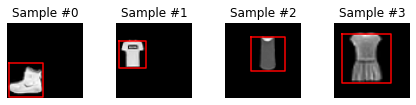

In [26]:
def show_bbox(image, bbox, pred=None):
    """Show image with bbox"""
    image = image.squeeze() #elimina dimensions 1
    plt.imshow(image, cmap='gray')

    # plot the ground truth bounding box
    imgsize = image.shape
    bbox *= [imgsize[1],imgsize[0],imgsize[0],imgsize[1]]
    plt.plot([bbox[0],bbox[0]+bbox[2],bbox[0]+bbox[2],bbox[0],bbox[0]],
             [bbox[1],bbox[1],bbox[1]+bbox[3],bbox[1]+bbox[3],bbox[1]], c='r')

    if pred is not None: 
        # plot the predicted bounding box (if provided)
        pred *= [imgsize[1],imgsize[0],imgsize[0],imgsize[1]]
        plt.plot([pred[0],pred[0]+pred[2],pred[0]+pred[2],pred[0],pred[0]],
                 [pred[1],pred[1],pred[1]+pred[3],pred[1]+pred[3],pred[1]], c='b')
    
    
fig = plt.figure()
for i in range(len(dataset1)):
    sample = dataset1[i]
    print(i, sample['image'].shape, sample['bbox'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bbox(**sample)

    if i == 3:
        plt.show()
        break

In [27]:
# check the size of the dataset
print("Size of training data: {}".format(len(dataset1)))
print("Size of test data: {}".format(len(dataset2)))

Size of training data: 60000
Size of test data: 10000


We have 60,000 images for training and 10,000 for testing. The image size is $64 \times 64$ pixels and they have only one channel (greyscale images).

## Create the CNN regression model

We will use a simple CNN model with four convolutional layers, one pooling layer, and two fully connected layers. 

Notice that the output layer has four neurons with a `sigmoid` activation, so our model produces at its outputs four real numbers (x, y, width, and height).

**Question: Why are we using a `sigmoid` activation? Can we use other activation functions in this model?**

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          )
        
        self.bbox = nn.Sequential(nn.Linear(32,4), nn.Sigmoid())
        
    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox(features)
        return bbox

summary(Net(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 4]             132
          Sigmoid-12                    [-1, 4]               0
Total params: 15,396
Trainable params: 15,396
Non-trainable params: 0
---------------------------------

### Define the training method

For training our CNN regression model we will use the L1 loss, which takes the mean element-wise absolute value difference.

See <a href="https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss">`torch.nn.L1Loss`</a> for details.

In [29]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target = sample_batched['bbox']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.l1_loss(output, target) # MAE
        loss_values.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None:
            scheduler.step()
    return loss_values

### Train the model

We will train the model with the [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) and the [`OneCycleLR`](https://pytorch.org/docs/stable/optim.html?highlight=onecyclelr#torch.optim.lr_scheduler.OneCycleLR) learning rate scheduler.

In [30]:
model = Net().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

log_interval = 100

loss_history_regression = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch, scheduler)
    loss_history_regression += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.204158
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.114494
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.101592
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.079281
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.067220
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.053810
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.048400
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.049473
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.047770
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.049548
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.046111
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.041319
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.035624
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.029281
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.031766
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.028659
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.031135
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.026269
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.032193
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027407
Train Epoch:

### Plot the loss over time

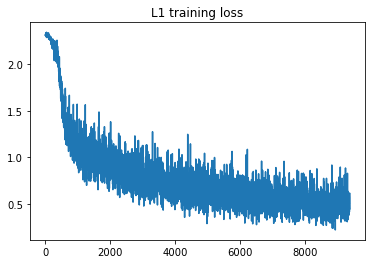

In [31]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.title('L1 training loss')
plt.show()

## Evaluate the model

Finally, we can use the trained model to predict a bounding box for any given image. Let's see how to make predictions for the first four images of the test set.

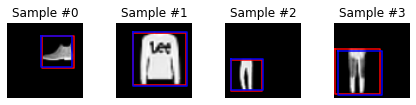

In [32]:
model.eval()

fig = plt.figure()
for i in range(len(dataset2)):
    sample = dataset2[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    # predict the bounding box for a given image
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        
    sample['pred'] = output[0].cpu().numpy()
    show_bbox(**sample)

    if i == 3:
        plt.show()
        break

In [33]:
def IoU(pred, target, iou_threshold = 0.7):
    # determine the coordinates of the intersection rectangle
    x_left = np.maximum(pred[:,0], target[:,0])
    y_top = np.maximum(pred[:,1], target[:,1])
    x_right = np.minimum(pred[:,0]+pred[:,2], target[:,0]+target[:,2])
    y_bottom = np.minimum(pred[:,1]+pred[:,3], target[:,1]+target[:,3])
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the areas of the union
    pred_area = pred[:,2] * pred[:,3]
    target_area =  target[:,2] *  target[:,3]
    
    union_area = pred_area + target_area - intersection_area
    
    iou = intersection_area / union_area
    
    return iou>iou_threshold

### Define the test method

In [34]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target = sample_batched['bbox']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.l1_loss(output, target).item()
            
            # count the number of prediction with an IoU above a certain threshold
            correct += np.sum(IoU(output.cpu().numpy(), target.cpu().numpy(), iou_threshold = 0.7))

    test_loss /= (len(test_loader.dataset)/test_loader.batch_size)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# call the test method
test(model, device, test_loader)


Test set: Average loss: 0.0136, Accuracy: 9872/10000 (99%)



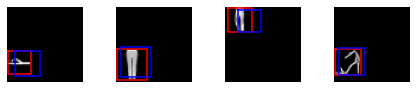

In [35]:
# Find wrong prediction and display it

model.eval()

count = 0

for i in range(len(dataset2)):
    sample = dataset2[i]
    
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
    
    target = sample['bbox'].reshape((1,4))
    iou= IoU(output.cpu().numpy(), target, iou_threshold = 0.7)
    
    if not iou:
        ax = plt.subplot(1, 4, count + 1)
        plt.tight_layout()
        ax.axis('off')
        sample['pred'] = output[0].cpu().numpy()
        show_bbox(**sample)
        count += 1
           
    if count == 4:
        plt.show()
        break





Now, we will create a second model with the objective of classifying the different images into its different classes:

In [36]:
# Add your code here
class FashionMNISTlocalizationDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True)

    def __len__(self):
        return self.fashionMnist.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize)
        image_width, image_height = self.imgsize
                
        # Get one Fashion-MNIST object, resize it randomly, and copy it into
        # a random location of the black image
        object_img = self.fashionMnist.data[idx,:,:]

        object_width  = object_height = np.random.randint(19,47)

        object_img = resize(object_img, (object_height, object_width))

        x_offset = np.random.randint(0,image_width-object_width)
        y_offset = np.random.randint(0,image_height-object_height)

        image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
        
        image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform:
            image = self.transform(image)

               
        sample = {'image': image, 'label': self.fashionMnist.targets[idx]}

        return sample
    
    
    
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform)
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform)

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          )
        
        self.label = nn.Sequential(nn.Linear(32,10))#, nn.Sigmoid())
        
    def forward(self, x):
        features = self.backbone(x)
        label = self.label(features)
        return label

summary(Net(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
Total params: 15,594
Trainable params: 15,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/ba

In [37]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target = sample_batched['label']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss_values.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()
        #optimizer.zero_grad()
        #loss_values.append(loss.detach().cpu())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None:
            scheduler.step()
    return loss_values

In [38]:
model = Net().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

log_interval = 100 # how many batches to wait before logging training status

loss_history = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch, scheduler)
    loss_history += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307948
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.279133
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.154833
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.439912
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.150750
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.216752
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.113703
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.953137
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.057760
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.005533
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.208328
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.693841
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.721437
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.609746
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.766260
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.846788
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.680621
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.705229
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.609723
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.802582
Train Epoch:

Let's observes the losses curves of the classification model and the detection model:

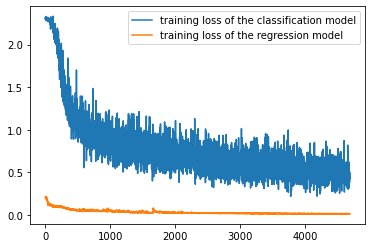

In [39]:
# Add your code here
import matplotlib.pyplot as plt
plt.plot(loss_history, label="training loss of the classification model")
plt.plot(loss_history_regression, label="training loss of the regression model")

plt.legend()
plt.show() 

Now, let's do another step: we will combine both models (classification and regression) in one. The model will have two outputs: the bounding box and the class label.

In [48]:
# Add your code here
class FashionMNISTlocalizationDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.fashionMnist = datasets.FashionMNIST('../data', train=train, download=True)

    def __len__(self):
        return self.fashionMnist.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # create a black image
        image = torch.zeros(self.imgsize)
        image_width, image_height = self.imgsize
                
        # Get one Fashion-MNIST object, resize it randomly, and copy it into
        # a random location of the black image
        object_img = self.fashionMnist.data[idx,:,:]

        object_width  = object_height = np.random.randint(19,47)

        object_img = resize(object_img, (object_height, object_width))

        x_offset = np.random.randint(0,image_width-object_width)
        y_offset = np.random.randint(0,image_height-object_height)

        image[y_offset:y_offset+object_height, x_offset:x_offset+object_width] += object_img
        
        image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform:
            image = self.transform(image)

        bbox = np.array([x_offset / image_width, y_offset / image_height, 
                         object_width / image_width, object_height / image_height], dtype=np.float32)
            
               
        sample = {'image': image, 'label': self.fashionMnist.targets[idx], 'bbox': bbox}

        return sample
    
    
    
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = FashionMNISTlocalizationDataset(train=True, transform=transform)
dataset2 = FashionMNISTlocalizationDataset(train=False, transform=transform)

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = nn.Sequential(
          nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
          nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
          nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
          nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          )
        
        self.label = nn.Sequential(nn.Linear(32,10))
        self.bbox = nn.Sequential(nn.Linear(32,4), nn.Sigmoid())
        #self.output = (nn.Sequential(nn.Linear(32,10)), nn.Sequential(nn.Linear(32,4), nn.Sigmoid())) # (label, bbox)
        
    def forward(self, x):
        features = self.backbone(x)
        out = (self.label(features), self.bbox(features))
        return out

summary(Net(),(1,64,64),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             208
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
              ReLU-8             [-1, 32, 4, 4]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
           Linear-12                    [-1, 4]             132
          Sigmoid-13                    [-1, 4]               0
Total params: 15,726
Trainable params: 

In [55]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    loss_values_classification, loss_values_regression, total_loss = [], [], []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target1 = sample_batched['label']
        target2 = sample_batched['bbox']
        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_classification = F.cross_entropy(output[0], target1)
        loss_values_classification.append(loss_classification.detach().cpu())
        
        loss_regression = F.l1_loss(output[1], target2)
        loss_values_regression.append(loss_regression.detach().cpu())
        
        total_loss.append(0.8*loss_regression.detach().cpu() + 0.2*loss_classification.detach().cpu())
        
        loss = 0.8*loss_regression + 0.2*loss_classification #com que la loss de la regressió és més petita l'augementem multiplicant-la per 8 per tal de que compti aproximadament el mateix que la de la classificació
        
        loss.backward()
        optimizer.step()
        #optimizer.zero_grad()
        #loss_values.append(loss.detach().cpu())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if scheduler is not None:
            scheduler.step()
    return total_loss, loss_values_regression, loss_values_classification

In [56]:
model = Net().to(device)

lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 5
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

log_interval = 100 # how many batches to wait before logging training status

loss_history, loss_regr, loss_class = [], [], []
for epoch in range(1, epochs + 1):
    total_loss_values, value_loss_regr, value_loss_class = train(model, device, train_loader, optimizer, epoch, scheduler)
    loss_history += total_loss_values
    loss_regr += value_loss_regr
    loss_class += value_loss_class

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.606186
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.536439
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.494686
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.423120
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.323502
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.344834
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.248654
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.353424
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.221143
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.279069
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.204340
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.247827
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.249964
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.206640
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.252634
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.185515
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.150757
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.181686
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.170739
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.233938
Train Epoch:

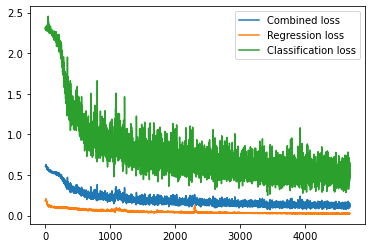

In [58]:
plt.plot(loss_history, label='Combined loss')
plt.plot(loss_regr, label='Regression loss')
plt.plot(loss_class, label='Classification loss')
plt.legend()
plt.show()

Finally, we will modify the test method with the objective to count as a correct output the correct prediction of the bounding box AND it's class label.

In [71]:
# Add your code here
def test(model, device, test_loader):
    model.eval()
    test_regr_loss = 0
    test_class_loss = 0
    test_total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target1 = sample_batched['label']
            target2 = sample_batched['bbox']
            data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
            output = model(data)
            a = F.l1_loss(output[1], target2).item()
            test_regr_loss += a
            b = F.cross_entropy(output[0], target1).item()
            test_class_loss += b
            test_total_loss += 0.8*a + 0.2*b
            
            
            # count the number of prediction with an IoU above a certain threshold and a correct classification
            correct += np.sum(np.argmax(output[0].cpu().numpy(), axis=1)==target1.cpu().numpy() * IoU(output[1].cpu().numpy(), target2.cpu().numpy(), iou_threshold = 0.7))

    test_regr_loss /= (len(test_loader.dataset)/test_loader.batch_size)
    test_class_loss /= (len(test_loader.dataset)/test_loader.batch_size)
    test_total_loss /= (len(test_loader.dataset)/test_loader.batch_size)

    print('\nTest set: Average regression loss: {:.4f}, Average classification loss: {:.4f}, Average combined loss: {:.4f} Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_regr_loss, test_class_loss, test_total_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# call the test method
test(model, device, test_loader)


Test set: Average regression loss: 0.0237, Average classification loss: 0.5486, Average combined loss: 0.1286 Accuracy: 6962/10000 (70%)

